In [1]:
from pprint import pprint
import requests
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def pnorm(x):
    q = math.erf(x / math.sqrt(2.0))
    return (1.0 + q) / 2.0

In [6]:
api_url = "http://auctions11.usydrobotics.club/api/fullLogs/"

log_names = eval(requests.request("GET", api_url + "stat").content)

logs = []

for i, name in enumerate(sorted(log_names, key=lambda s: s[:-4].split('_')[-1])[-500:]):
    log = requests.request("GET", api_url + name).content.strip()
    log = iter([comp for comp in log.split(b'/') if comp])
    teams = eval(next(log))
    bots, tv_mean, tv_std = next(log).split(b'|')
    bots = bots.split(b',')
    tv_mean, tv_std = int(tv_mean), int(tv_std)
    
    game = {
        "name": name,
        "teams": teams,
        "bots": bots,
        "tv_mean": tv_mean,
        "tv_std": tv_std,
        "auctions": []
    }
    for chunks in log:
        auction = {
            "tv": 0,
            "know": [],
            "bids": []
        }

        for chunk in chunks.split(b'|'):
            if chunk.startswith(b't:'):
                auction["tv"] = int(chunk.split(b':')[1])
            elif chunk.startswith(b'k:'):
                auction["know"].append(int(chunk.split(b':')[1]))
            elif chunk.startswith(b'r:'):
                pass
            elif chunk.startswith(b's:'):
                pass
            elif chunk.startswith(b'R:'):
                pass
            elif chunk.startswith(b'S:'):
                pass
            else:
                auction["bids"].append(tuple(map(int, chunk.split(b':'))))
        game["auctions"].append(auction)
    
    logs.append(game)

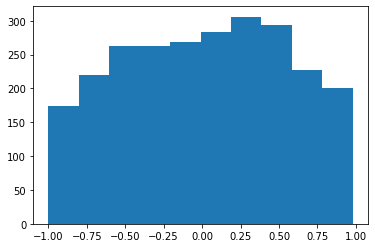

In [8]:
z_scores = []
for game in logs:
    for auction in game["auctions"]:
        z_scores.append((auction["tv"] - game["tv_mean"]) / game["tv_std"])

plt.hist(z_scores)
plt.show()

235620


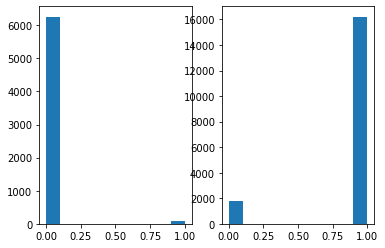

In [56]:
stage_prob = {
    "low": 0.64,
    "mid": 0.16,
    "high": 0.04
}

def get_stage(value, mean):
    if value > mean * 3 / 4:
        return "high"
    elif value > mean / 4:
        return "mid"
    else:
        return "low"

npc_p_values = []
player_p_values = []

for game_index, game in enumerate(logs):
    
    tv_mean = game["tv_mean"]

    stage_bid_counts = {
        "low": [0 for _ in range(10)],
        "mid": [0 for _ in range(10)],
        "high": [0 for _ in range(10)]
    }
    stage_round_counts = {
        "low": 0,
        "mid": 0,
        "high": 0
    }
    
    for auction in game["auctions"]:
        last_bid_index = 0
        last_bid = 1
        for who, bid in auction["bids"]:
            stage_bid_counts[get_stage(bid, tv_mean)][who] += 1
            if last_bid_index > who:
                stage_round_counts[get_stage(bid, tv_mean)] += 1
            last_bid = bid
            last_bid_index = who
    
        for i in range(10):
            p_values = []
            for stage, prob in stage_prob.items():
                if stage_round_counts[stage] == 0:
                    continue
                x = stage_bid_counts[stage][i] / stage_round_counts[stage]
                mean = prob
                sd = math.sqrt(prob * (1 - prob) / stage_round_counts[stage])
                test_stat = (x - mean) / sd
                p_values.append(2 * pnorm(-abs(test_stat)))
            if game["bots"][i] == b"NPC":
                npc_p_values.append(int(any(map(lambda p: p < 0.00085, p_values))))
            elif game["bots"][i] != b"CHRISTIE":
                player_p_values.append(int(any(map(lambda p: p < 0.00085, p_values))))

print(npc_p_values.count(True) * -90
      + player_p_values.count(True) * 15)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(npc_p_values)
ax2.hist(player_p_values)
plt.show()